In [1]:
import os
from multiprocessing import cpu_count
from random import randint

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import wandb
from layer.mish import Mish
from layer.rademacher_dropout import RademacherDropout
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer
from torch import nn, optim
from torch.utils.data import ConcatDataset, DataLoader, Dataset
from torchvision import models, transforms
from tqdm.auto import tqdm, trange
from trainer import Trainer

from dataset.facialexpressions import FacialExpressionsDataset
from dataset.ferplus import FERPlusDataset

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
train_transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
predict_transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [4]:
trainset = ConcatDataset(
    [
        FacialExpressionsDataset(
            "../dataset/facial_expressions", transform=train_transform
        ),
        FERPlusDataset("../dataset/FERPlus", "train", transform=train_transform),
    ]
)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=cpu_count())
trainloader_not_shuffled = DataLoader(
    trainset, batch_size=32, shuffle=False, num_workers=cpu_count()
)
len(trainset)

42748

In [5]:
classes = set()
for dataset in trainset.datasets:
    classes = classes.union(set(dataset.emotions))

lb = LabelBinarizer()
classes = list(classes)
lb.classes_ = np.asarray(classes)
print(lb.classes_)

['NF' 'happy' 'sad' 'surprise' 'disgust' 'fear' 'uncertain' 'contempt'
 'neutral' 'anger']


In [6]:
def show_dataset(dataset, n=5):
    pil_transform = transforms.ToPILImage()
    img = np.vstack(
        np.hstack([pil_transform(dataset[i][0]) for _ in range(5)])
        for i in [randint(0, len(dataset)) for _ in range(n)]
    )
    plt.imshow(img)

<ipython-input-6-acce69bc3967>:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  img = np.vstack(


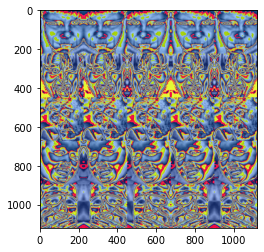

In [7]:
show_dataset(trainset)

In [8]:
valset = FERPlusDataset("../dataset/FERPlus", "val", transform=predict_transform)
valloader = DataLoader(valset, batch_size=16, shuffle=False, num_workers=cpu_count())
testset = FERPlusDataset("../dataset/FERPlus", "test", transform=predict_transform)
testloader = DataLoader(testset, batch_size=16, shuffle=False, num_workers=cpu_count())

len(valset), len(testset)

(3579, 3573)

In [9]:
class FacialExpressionsClassifier(nn.Module):
    def __init__(self, base_model, output):
        super().__init__()
        self.base_model = base_model
        self.output = output
        self.fc1 = nn.Linear(list(model_base.children())[-1].out_features, 512)
        self.fc2 = nn.Linear(512, output)
        #         self.dropout = nn.Dropout(0.5)
        self.dropout = RademacherDropout()

    def forward(self, image):
        x = self.base_model(image)
        x = self.dropout(x)
        #         x = F.relu(self.fc1(x))
        x = Mish()(self.fc1(x))
        x = self.dropout(x)
        outs = self.fc2(x)
        return outs

In [10]:
# torch.hub.list('zhanghang1989/ResNeSt', force_reload=True)
# final_model = torch.hub.load('zhanghang1989/ResNeSt', 'resnest50', pretrained=True)

In [11]:
# model_base = models.resnet50(pretrained=True)
# final_model = FacialExpressionsClassifier(model_base, len(classes))
final_model = models.resnet50(pretrained=True)
final_model.fc = nn.Linear(2048, len(classes))
final_model = final_model.to(device)
final_model

Using cache found in /home/yusufrahadika/.cache/torch/hub/pytorch_vision_v0.6.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [12]:
criterion = nn.CrossEntropyLoss()

In [13]:
# trainer = Trainer(
#     "facial-expressions-essay",
#     final_model,
#     device,
#     trainloader,
#     classes,
#     criterion,
#     valloader=valloader,
#     optimizer_params={"lr": 0.001, "momentum": 0.9},
#     gradient_accumulation=2,
#     max_step=1000,
# )
# trainer.train()

In [14]:
def predict(model, dataloader, device):
    model.eval()
    y_pred = []
    for i, (inputs, _) in enumerate(dataloader):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.append(predicted)

    return torch.cat(y_pred).cpu().numpy()

In [15]:
%%timeit
y_test_pred = predict(final_model, testloader, device)
y_test_actual = np.asarray(
    [classes.index(target) for _, targets in testloader for target in targets]
)

11.3 s ± 51.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
"Test accuracy:", accuracy_score(y_test_actual, y_test_pred)

NameError: name 'y_test_actual' is not defined

In [ ]:
wandb.sklearn.plot_confusion_matrix(y_test_actual, y_test_pred, classes)